In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import torch
import torch.nn as nn
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='ggplot')
%matplotlib inline

# Exploration

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')
test_id = test['id']
target = train['target']
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [3]:
print(train.shape)
train.head()

(300000, 25)


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,A,B,A,A,B,D,A,E,C,I,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,B,A,A,A,B,B,A,E,A,F,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,A,A,A,C,B,D,A,B,C,N,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,A,A,A,C,B,D,A,E,G,K,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,A,B,A,A,B,B,A,E,C,F,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [4]:
print(test.shape)
test.head()

(200000, 24)


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,A,B,A,C,B,D,A,E,E,G,0.331261,0.551131,0.486284,0.156058,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,A,B,A,C,B,D,A,E,C,L,0.402404,0.617546,0.296852,0.187440,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,A,B,A,C,B,D,A,E,C,F,0.530677,0.618126,0.760865,0.199872,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,A,A,B,A,B,D,A,E,E,F,0.439653,0.487403,0.715786,0.192808,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,A,B,A,A,B,B,A,E,E,I,0.389844,0.752760,0.315269,0.191734,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


In [5]:
sample.head()

,id,target
0,0,0.5
1,5,0.5
2,15,0.5
3,16,0.5
4,17,0.5


In [6]:
print(train.info())
print("=====================")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

<AxesSubplot:>

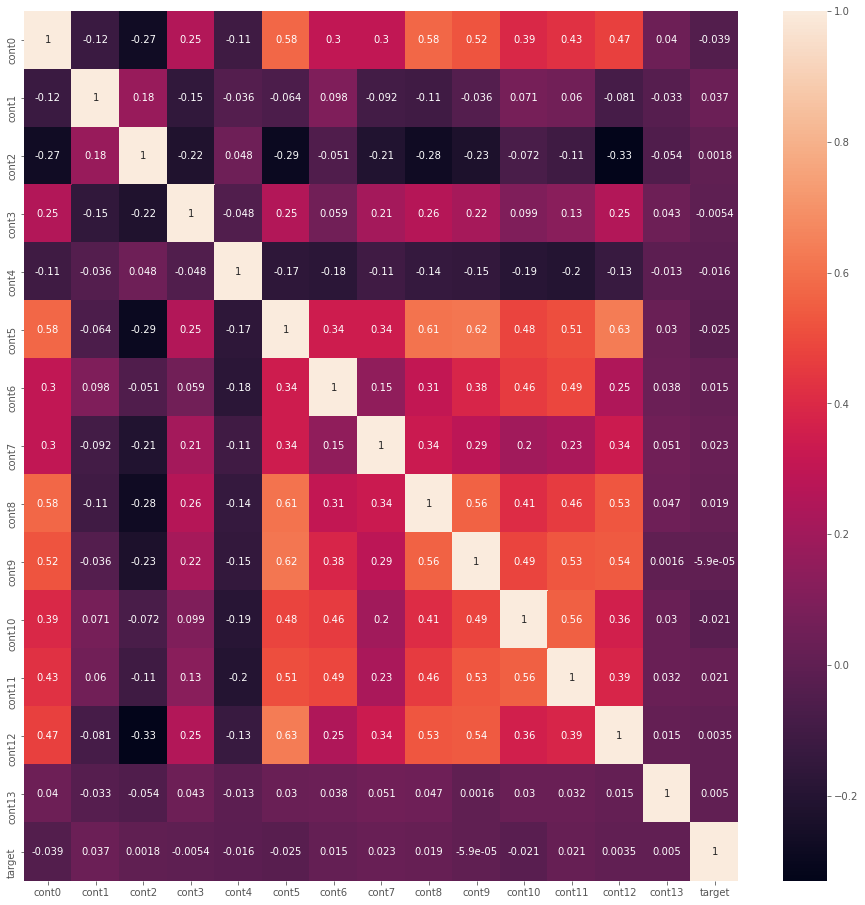

In [7]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True)

# Data Cleaning

Check if any value from the categorical variable is not in train or test

In [8]:
cat = train.select_dtypes(include=object)
for i in cat:
    uniquetrain = train[i].unique()
    uniquetest = test[i].unique()
    print(i)
    print(uniquetrain)
    print(uniquetest)
    print("-----------------------")

cat0
['A' 'B']
['A' 'B']
-----------------------
cat1
['B' 'A']
['B' 'A']
-----------------------
cat2
['A' 'B']
['A' 'B']
-----------------------
cat3
['A' 'C' 'D' 'B']
['C' 'A' 'D' 'B']
-----------------------
cat4
['B' 'C' 'A' 'D']
['B' 'A' 'C' 'D']
-----------------------
cat5
['D' 'B' 'A' 'C']
['D' 'B' 'A' 'C']
-----------------------
cat6
['A' 'B' 'D' 'C' 'E' 'I' 'G' 'H']
['A' 'B' 'C' 'D' 'E' 'I' 'H']
-----------------------
cat7
['E' 'B' 'D' 'G' 'F' 'A' 'C' 'I']
['E' 'D' 'B' 'G' 'F' 'I' 'A' 'C']
-----------------------
cat8
['C' 'A' 'G' 'E' 'D' 'F' 'B']
['E' 'C' 'D' 'G' 'A' 'F' 'B']
-----------------------
cat9
['I' 'F' 'N' 'K' 'B' 'L' 'G' 'H' 'O' 'A' 'J' 'M' 'C' 'D' 'E']
['G' 'L' 'F' 'I' 'A' 'K' 'M' 'O' 'N' 'H' 'B' 'J' 'C' 'E' 'D']
-----------------------


In [9]:
print(train.shape)
todrop = train[train['cat6'] == 'G'].index
train.drop(todrop, axis=0, inplace=True)
print(train.shape)

(300000, 25)
(299997, 25)


## Skewness

In [10]:
train.skew()

cont0     0.509880
cont1    -0.726462
cont2     0.171003
cont3     0.401534
cont4     0.743695
cont5     0.511147
cont6     0.871001
cont7     0.705154
cont8     0.725131
cont9     0.223224
cont10    0.084650
cont11   -0.030753
cont12    0.372885
cont13    0.130783
target   -0.201263
dtype: float64

# EDA

### Target

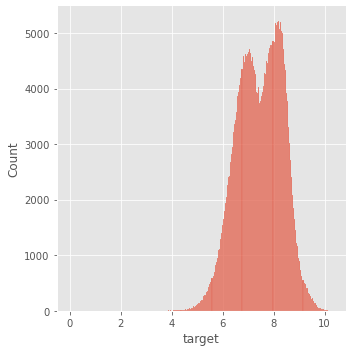

In [11]:
sns.displot(train['target'])

<AxesSubplot:xlabel='target'>

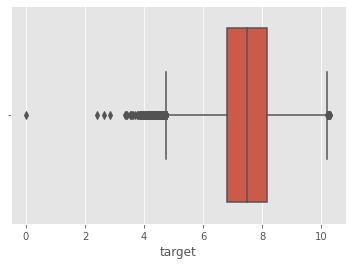

In [12]:
sns.boxplot(train['target'])

In [13]:
print(train.shape)
todrop = train[train['target'] < 3].index
train.drop(todrop, axis=0, inplace=True)
print(train.shape)

(299997, 25)
(299993, 25)


### cat0

In [14]:
print(train['cat0'].value_counts())
print(test['cat0'].value_counts())

A    281466
B     18527
Name: cat0, dtype: int64
A    187700
B     12300
Name: cat0, dtype: int64


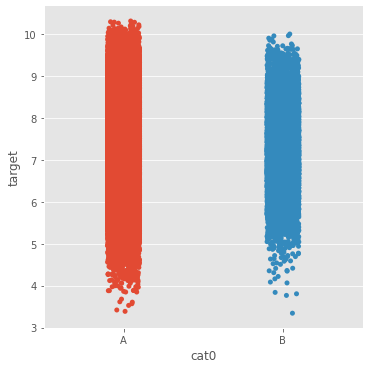

In [15]:
sns.catplot('cat0', 'target', data=train)

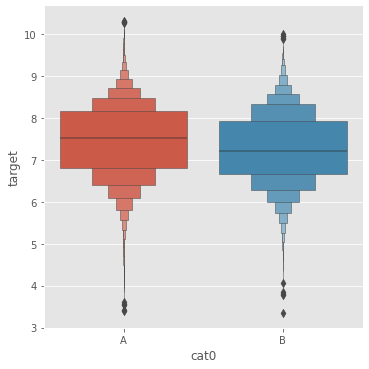

In [16]:
sns.catplot('cat0', 'target', data=train, kind='boxen')

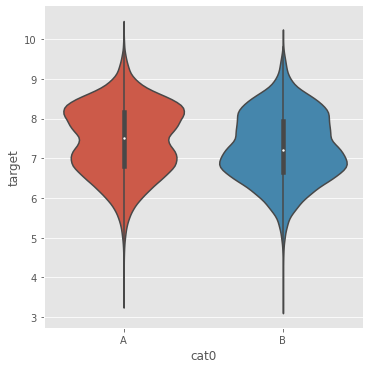

In [17]:
sns.catplot('cat0', 'target', data=train, kind='violin')

### cat1

In [18]:
train['cat1'].value_counts()

A    162675
B    137318
Name: cat1, dtype: int64

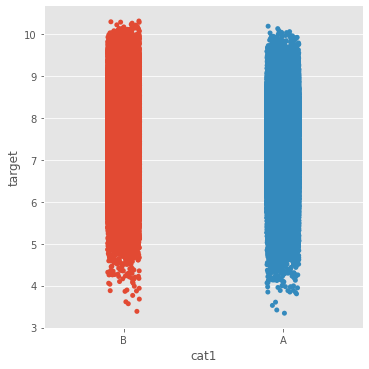

In [19]:
sns.catplot('cat1', 'target', data=train)

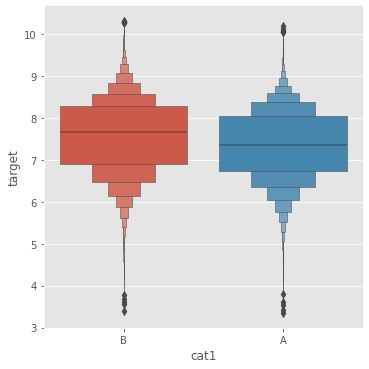

In [20]:
sns.catplot('cat1', 'target', data=train, kind='boxen')

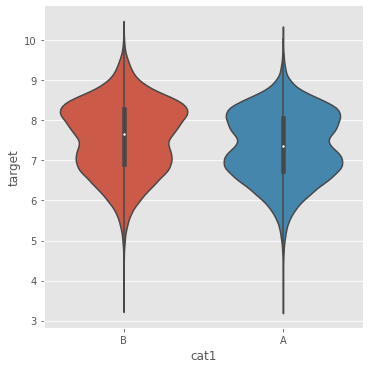

In [21]:
sns.catplot('cat1', 'target', data=train, kind='violin')

### cat2

In [22]:
train['cat2'].value_counts()

A    276544
B     23449
Name: cat2, dtype: int64

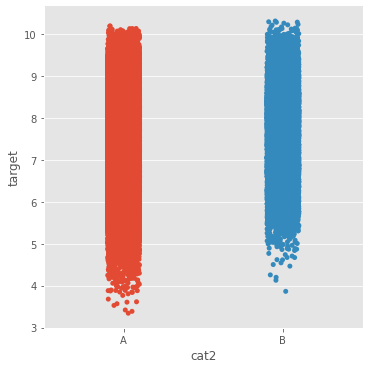

In [23]:
sns.catplot('cat2', 'target', data=train)

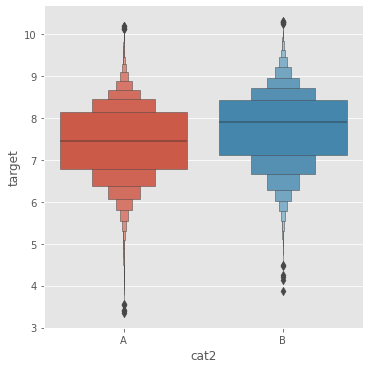

In [24]:
sns.catplot('cat2', 'target', data=train, kind='boxen')

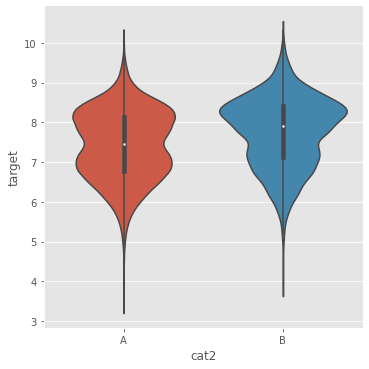

In [25]:
sns.catplot('cat2', 'target', data=train, kind='violin')

### cat3

In [26]:
train['cat3'].value_counts()

C    183750
A    104459
D     11174
B       610
Name: cat3, dtype: int64

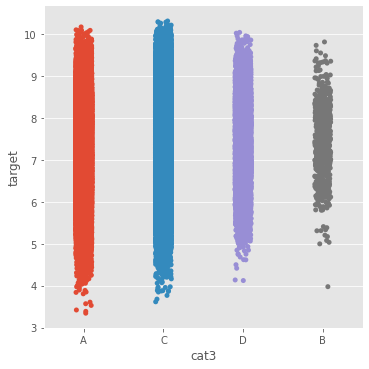

In [27]:
sns.catplot('cat3', 'target', data=train)

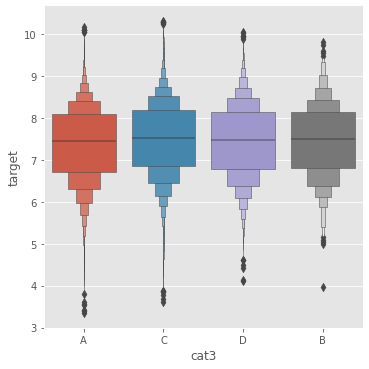

In [28]:
sns.catplot('cat3', 'target', data=train, kind='boxen')

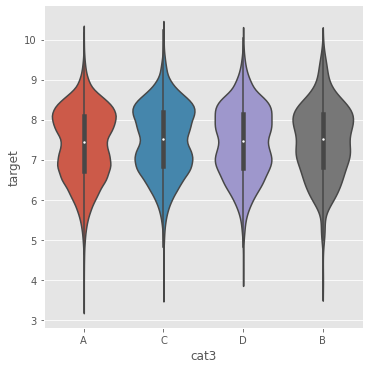

In [29]:
sns.catplot('cat3', 'target', data=train, kind='violin')

### cat4

In [30]:
train['cat4'].value_counts()

B    297366
A      1241
C       767
D       619
Name: cat4, dtype: int64

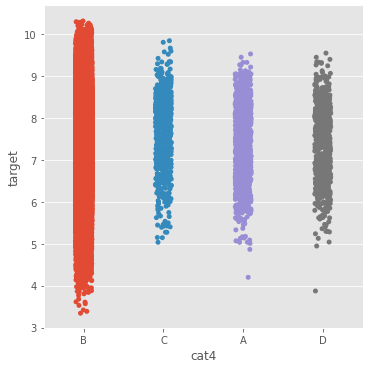

In [31]:
sns.catplot('cat4', 'target', data=train)

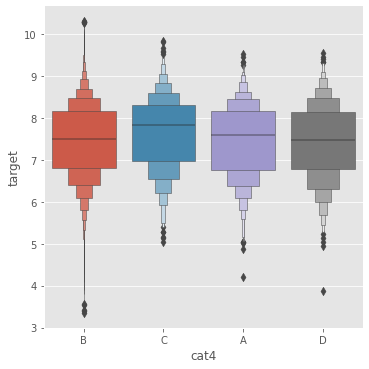

In [32]:
sns.catplot('cat4', 'target', data=train, kind='boxen')

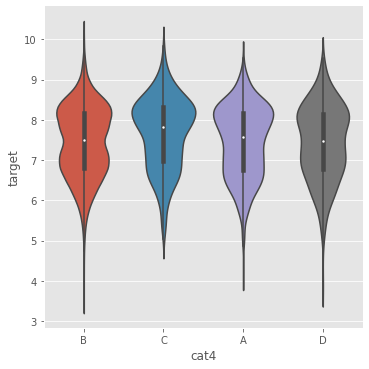

In [33]:
sns.catplot('cat4', 'target', data=train, kind='violin')

<AxesSubplot:xlabel='cat4', ylabel='target'>

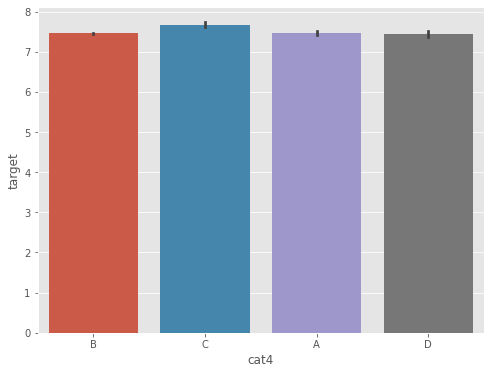

In [34]:
plt.figure(figsize=(8, 6))
sns.barplot('cat4', 'target', data=train)

We can generate is C feature

In [35]:
# TODO

### cat5

In [36]:
train['cat5'].value_counts()

B    149204
D    135149
C     11763
A      3877
Name: cat5, dtype: int64

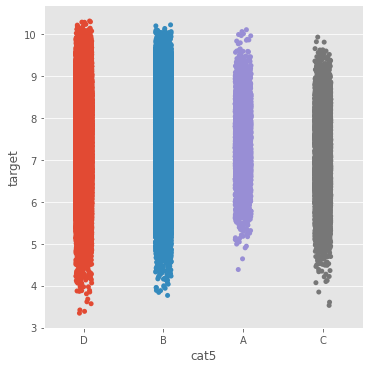

In [37]:
sns.catplot('cat5', 'target', data=train)

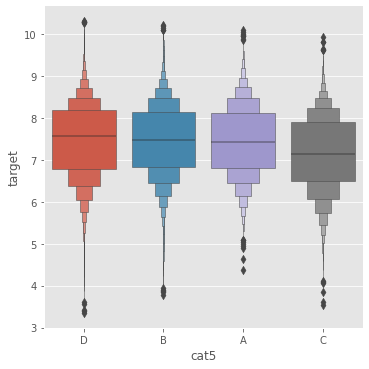

In [38]:
sns.catplot('cat5', 'target', data=train, kind='boxen')

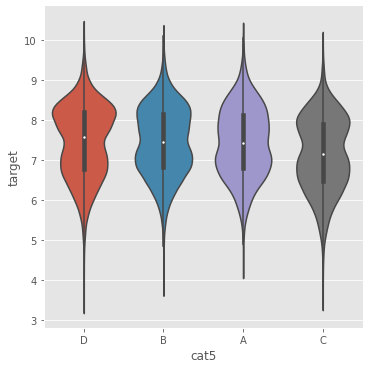

In [39]:
sns.catplot('cat5', 'target', data=train, kind='violin')

### cat6

In [40]:
train['cat6'].value_counts()

A    292639
B      6344
C       809
D       147
I        24
E        19
H        11
Name: cat6, dtype: int64

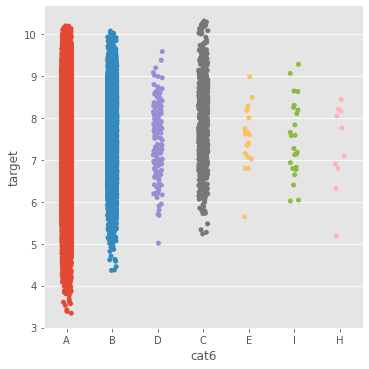

In [41]:
sns.catplot('cat6', 'target', data=train)

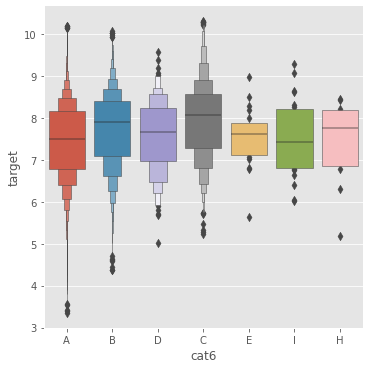

In [42]:
sns.catplot('cat6', 'target', data=train, kind='boxen')

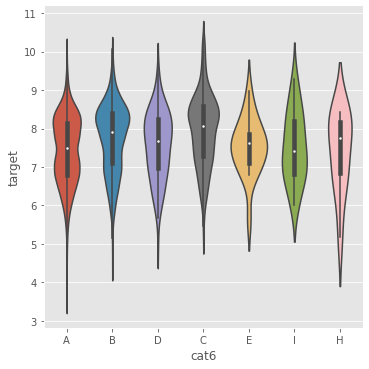

In [43]:
sns.catplot('cat6', 'target', data=train, kind='violin')

<AxesSubplot:xlabel='cat6', ylabel='target'>

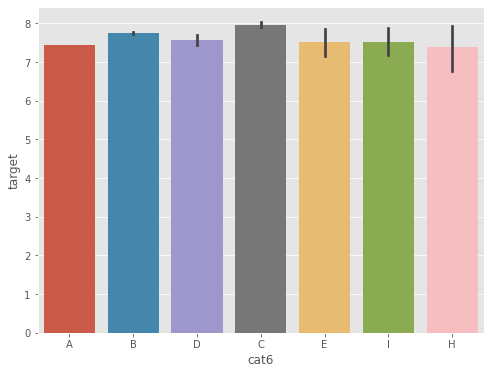

In [44]:
plt.figure(figsize=(8, 6))
sns.barplot('cat6', 'target', data=train)

We can generate is not A feature

In [45]:
# TODO

### cat7

In [46]:
train['cat7'].value_counts()

E    267625
D     24355
B      5750
G      1961
F       279
A        14
C         6
I         3
Name: cat7, dtype: int64

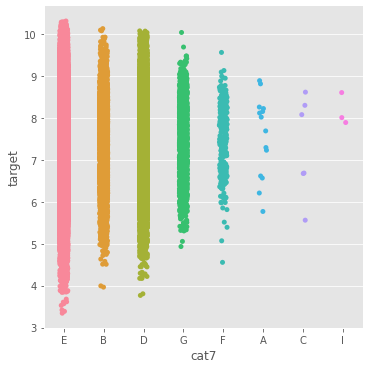

In [47]:
sns.catplot('cat7', 'target', data=train)

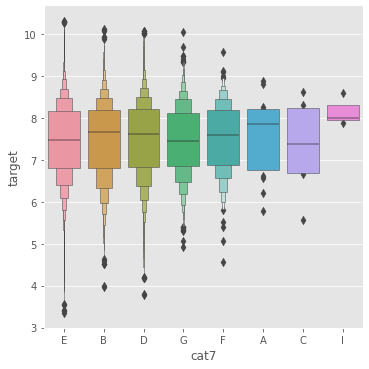

In [48]:
sns.catplot('cat7', 'target', data=train, kind='boxen')

In [ ]:
sns.catplot('cat7', 'target', data=train, kind='violin')

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot('cat7', 'target', data=train)

We can generate is A or G or I feature

In [ ]:
# TODO

### cat8

In [ ]:
train['cat8'].value_counts()

In [ ]:
sns.catplot('cat8', 'target', data=train)

In [ ]:
sns.catplot('cat8', 'target', data=train, kind='boxen')

In [ ]:
sns.catplot('cat8', 'target', data=train, kind='violin')

### cat9

In [ ]:
train['cat9'].value_counts()

In [ ]:
sns.catplot('cat9', 'target', data=train)

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot('cat9', 'target', data=train)

We can generate is C or D or E feautre

In [ ]:
# TODO

### cont0

In [ ]:
sns.boxplot(train['cont0'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont0'], train['target'])

We can generate is cont0 < 0.3 feautre

In [ ]:
# TODO

### cont1

In [ ]:
sns.boxplot(train['cont1'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont1'], train['target'])

### cont2

In [ ]:
sns.boxplot(train['cont2'])

In [ ]:
sns.boxplot(test['cont2'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont2'], train['target'])

## cont3

In [ ]:
sns.boxplot(train['cont3'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont3'], train['target'])

### cont4

In [ ]:
sns.boxplot(train['cont4'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont4'], train['target'])

### cont5

In [ ]:
sns.boxplot(train['cont5'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont5'], train['target'])

### cont6

In [ ]:
sns.boxplot(train['cont6'])

In [ ]:
sns.boxplot(test['cont6'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont6'], train['target'])

### cont7

In [ ]:
sns.boxplot(train['cont7'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont7'], train['target'])

### cont8

In [ ]:
sns.boxplot(train['cont8'])

In [ ]:
sns.boxplot(test['cont8'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont8'], train['target'])

We can generate is cont8 > 0.9 feature

In [ ]:
# TODO

### cont9

In [ ]:
sns.boxplot(train['cont9'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont9'], train['target'])

### cont10

In [ ]:
sns.boxplot(train['cont10'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont10'], train['target'])

### cont11

In [ ]:
sns.boxplot(train['cont11'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont11'], train['target'])

### cont12

In [ ]:
sns.boxplot(train['cont12'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont12'], train['target'])

We can generate is cont12 < .02 feature

In [ ]:
# TODO

### cont13

In [ ]:
sns.boxplot(train['cont13'])

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(train['cont13'], train['target'])

# Encdoing categorical features

In [ ]:
print(train.shape, test.shape)
train.drop('target', axis=1, inplace=True)
train = pd.get_dummies(train)
test = pd.get_dummies(test)
print(train.shape, test.shape)

In [ ]:
train.head()

# Modelling

In [ ]:
# TODO